**<span style="color:#809bd8">S30 - Evidencia de aprendizaje 2. Optimizando la productividad en el mundo del software
</span>**

**<span style="color:#809bd8">Programa:</span>** Ingeniería en desarollo de software y datos

**<span style="color:#809bd8">Asignatura:</span>** Programación para Análisis de Datos

**<span style="color:#809bd8">Grupo:</span>** PREICA2402B020101

**<span style="color:#809bd8">Docente:</span>** Andrés Felipe Palacio

**<span style="color:#809bd8">Estudiante:</span>** Mateo Ospina Agudelo

**<span style="color:#809bd8">Universidad:</span>** Institución Universitaria Digital de Antioquia – IUDIGITAL


**Introducción**

**Descripción de la página y artículo a analizar**

La página web elegida para el scraping es BuscaLibre, un marketplace especializado en la venta de libros. El foco del análisis estará puesto en la clasificación de 'Libros más vendidos' en la categoria de ciencia ficción. A través de la extracción de datos de cada libro listado, se busca construir una base de datos que permita realizar un análisis más profundo del mercado editorial actual y las preferencias de los lectores en la plataforma.

**Descripción del tema de interés que deseas desarrollar en la primera práctica**

Identificación de los elementos clave que contribuyen al éxito de los libros de ciencia ficción en la plataforma BuscaLibre. Se realizará un análisis exhaustivo de los libros de ciencia ficción más vendidos, considerando factores como el título, el autor, la editorial, el precio, el número de páginas y las calificaciones de los usuarios. A través de este análisis, se busca determinar cuáles son las características más comunes de los libros de ciencia ficción que logran posicionarse en los primeros lugares de la clasificación y qué factores influyen en las decisiones de compra de los lectores.

**Objetivos: formula los objetivos a partir de la siguiente pregunta: ¿por qué deseas analizar este artículo y la empresa de comercio?**

* Comprender las preferencias de los lectores de ciencia ficción en BuscaLibre: Identificar los elementos que hacen que un libro de ciencia ficción sea popular entre los usuarios de esta plataforma.
* Caracterizar el mercado de la ciencia ficción en BuscaLibre: Describir las principales características del mercado de la ciencia ficción en BuscaLibre, incluyendo los autores más destacados y las editoriales líderes.
* Identificar oportunidades de mejora para BuscaLibre: Sugerir posibles estrategias para mejorar la oferta de libros de ciencia ficción en la plataforma, basadas en los resultados del análisis.

**Metodología empleada de scraping**
Se ha empleado Selenium para el scraping de datos en BuscaLibre debido a la naturaleza dinámica de su contenido. A diferencia de BeautifulSoup, que está diseñada para parsear HTML estático, Selenium permite interactuar con páginas web que cargan contenido de forma asíncrona, como es el caso de BuscaLibre. Por otro lado, aunque Scrapy es una herramienta potente para proyectos a gran escala, su configuración inicial resulta más compleja y no es necesaria para un proyecto de menor envergadura como este. Selenium ofrece la flexibilidad y facilidad de uso necesarias para extraer los datos requeridos de manera eficiente.

**Resultados y conclusiones**




In [1]:
%pip install selenium

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Importación de los paquetes de que se van a utilizar
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
import re
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# Configuración del driver
options= webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

In [5]:
driver = webdriver.Chrome(options=options)

# Link de los libros de ciencia ficción
url = "https://www.buscalibre.com.co/libros/ficcion/ciencia-ficcion"

# Vamos a la pagina
driver.get(url)

# Esperar a que el botón "Ordenar" esté visible y listo para hacer clic
boton_ordenar = WebDriverWait(driver, 10).until(
    EC.element_to_be_clickable((By.XPATH, '//div[normalize-space()="Ordenar"]'))
)
boton_ordenar.click()

# Esperar a que el botón "Más vendidos" esté visible y listo para hacer clic
boton_ordenar_mas_vendidos = WebDriverWait(driver, 10).until(
    EC.element_to_be_clickable((By.CSS_SELECTOR, "label[for='sales']"))
)
boton_ordenar_mas_vendidos.click()

# Esperar a que se cargue la página con el contenido ordenado
WebDriverWait(driver, 10).until(
    EC.presence_of_all_elements_located((By.XPATH, '//div[contains(@class, "box-producto")]'))
)

lista_libros = []
existen_mas_libros_o_paginas = True
# Función para obtener los detalles de un libro
def obtener_detalles_libro(libro):
    titulo = libro.find_element(By.XPATH, './/h3[contains(@class, "nombre")]').text
    autor_elementos = libro.find_elements(By.XPATH, './/div[@class="autor"]')
    autor = autor_elementos[0].text if autor_elementos else None

    # Obtener editorial
    editorial = obtener_editorial(libro)
    
    # Obtener estrellas y calificaciones
    estrellas, calificaciones = obtener_estrellas_y_calificaciones(libro)
    
    # Obtener precio
    precio = libro.find_element(By.XPATH, './/p[contains(@class, "precio-ahora")]').text

    return {
        'titulo': titulo,
        'autor': autor,
        'editorial': editorial,
        'precio': precio,
        'estrellas': estrellas,
        'cantidad_calificaciones': calificaciones
    }

# Función para obtener la editorial
def obtener_editorial(libro):
    editorial_elementos = libro.find_elements(By.XPATH, './/div[@class="autor"]/following::div[contains(@class, "autor")]')
    if editorial_elementos:
        return editorial_elementos[0].text.split(',')[0]
    return None

# Función para obtener estrellas y calificaciones
def obtener_estrellas_y_calificaciones(libro):
    estrellas_y_calificaciones_elementos = libro.find_elements(By.XPATH, './/div[contains(@class, "box-stars")]')
    if estrellas_y_calificaciones_elementos:
        estrellas_element = estrellas_y_calificaciones_elementos[0].find_elements(By.XPATH, './/span[contains(@class, "stars")]')
        if estrellas_element:
            clase_estrellas = estrellas_element[0].get_attribute('class')
            match = re.search(r'stars-(\d+)', clase_estrellas)
            if match:
                estrellas = int(match.group(1))
                # Convertir a decimal si es mayor a 9. Esto se hace porque cuando la calificación es 45, en la página se muestra como 4.5, además la calificación máxima es 5
                if estrellas > 9:
                    estrellas /= 10

            calificaciones_elements = estrellas_element[0].find_elements(By.XPATH, 'following-sibling::span')
            if calificaciones_elements:
                calificaciones = calificaciones_elements[0].text.strip('()')
                return estrellas, calificaciones
    return None, None

def esperar_elemento(driver, xpath, tiempo_espera=10):
    try: 
        WebDriverWait(driver, tiempo_espera).until( EC.presence_of_element_located((By.XPATH, xpath)) ) 
        return True 
    except TimeoutException: 
        return

# Función para pasar a la siguiente página
def pasar_a_siguiente_pagina(driver):
    # Buscar si existe el botón siguiente
    siguiente_pagina = driver.find_elements(By.XPATH, '//span[@id="pagnNextString"]')
    
    # Si no existe el botón, estamos en la última página
    if not siguiente_pagina:
        print("Has llegado a la última página.")
        return False
        
    # Si existe, hacer click y esperar que carguen los productos
    siguiente_pagina[0].click()
    if esperar_elemento(driver, '//div[contains(@class, "box-producto")]'):
        return True
    else:
        print("No se encontraron más libros en la página.")
        return False

# Iterar sobre todas las páginas de la categoría
lista_libros = []
existen_mas_libros_o_paginas = True

while existen_mas_libros_o_paginas:
    libros = driver.find_elements(By.XPATH, '//div[contains(@class, "box-producto")]')
    
    if not libros:
        print("No se encontraron más libros en la página.")
        break

    for libro in libros:
        detalles_libro = obtener_detalles_libro(libro)
        lista_libros.append(detalles_libro)
    
    existen_mas_libros_o_paginas = pasar_a_siguiente_pagina(driver)

driver.quit()

No se encontraron más libros en la página.


In [6]:
# Crear un DataFrame con los datos obtenidos
df = pd.DataFrame(lista_libros)

df.head()

,titulo,autor,editorial,precio,estrellas,cantidad_calificaciones
0,1984,George Orwell,Blanco & Negro,$ 39.760,5.0,23
1,Ensayo sobre la ceguera,José Saramago,Debolsillo,$ 32.830,5.0,77
2,Kafka en la Orilla,Haruki Murakami,Tusquets,$ 45.000,5.0,68
3,Cartas del Diablo a Su Sobrino,C. S. Lewis,HarperOne,$ 55.396,5.0,13
4,Un Mundo Feliz,Aldous Huxley,Skala,$ 13.125,4.5,37


In [7]:
print (lista_libros)
print (len(lista_libros))

[{'titulo': '1984', 'autor': 'George Orwell', 'editorial': 'Blanco & Negro', 'precio': '$ 39.760', 'estrellas': 5, 'cantidad_calificaciones': '23'}, {'titulo': 'Ensayo sobre la ceguera', 'autor': 'José Saramago', 'editorial': 'Debolsillo', 'precio': '$ 32.830', 'estrellas': 5, 'cantidad_calificaciones': '77'}, {'titulo': 'Kafka en la Orilla', 'autor': 'Haruki Murakami', 'editorial': 'Tusquets', 'precio': '$ 45.000', 'estrellas': 5, 'cantidad_calificaciones': '68'}, {'titulo': 'Cartas del Diablo a Su Sobrino', 'autor': 'C. S. Lewis', 'editorial': 'HarperOne', 'precio': '$ 55.396', 'estrellas': 5, 'cantidad_calificaciones': '13'}, {'titulo': 'Un Mundo Feliz', 'autor': 'Aldous Huxley', 'editorial': 'Skala', 'precio': '$ 13.125', 'estrellas': 4.5, 'cantidad_calificaciones': '37'}, {'titulo': 'Crónicas Marcianas', 'autor': 'Ray Bradbury', 'editorial': 'Minotauro', 'precio': '$ 38.500', 'estrellas': 5, 'cantidad_calificaciones': '24'}, {'titulo': 'Las Crónicas de Narnia', 'autor': 'C. S. Lew

In [8]:
# En el orden en que estan los libros añadir una columna con el número de libro, es decir, el primer libro tiene el número 1, el segundo el número 2, y así sucesivamente.
# Esto es para que se identifique los libros por orden de mas vendidos ya que al hacer el scraping se obtienen los libros en ese orden.
df['numero_libro'] = range(1, len(df) + 1)

In [9]:
# modifica el nombre de la variable numero_libro por numero_libro_mas_vendido, y se vuelve categorica para que no se realicen operaciones matematicas con ella.
df = df.rename(columns={'numero_libro': 'numero_libro_mas_vendido'})
df['numero_libro_mas_vendido'] = df['numero_libro_mas_vendido'].astype('category')


In [10]:
df.describe()

,estrellas
count,990.000000
mean,4.814141
std,0.448908
min,1.000000
25%,5.000000
50%,5.000000
75%,5.000000
max,5.000000


In [11]:
df.autor.value_counts( dropna=False)

autor
Philip K. Dick               51
Ray Bradbury                 48
Wells, H. G.                 41
Verne, Jules                 34
Isaac Asimov                 31
                             ..
Phillips, John-Michael P.     1
Miniet, Daniel                1
Rice, Lilyanne                1
Rhodes, Dave                  1
Graham, Jo                    1
Name: count, Length: 7637, dtype: int64

In [12]:
df.editorial.value_counts( dropna=False)

editorial
Createspace Independent Publishing Platform    1566
Independently Published                        1126
Lulu.Com                                        469
Createspace                                     315
Minotauro                                       291
                                               ... 
Clocktower Books                                  1
Rightword Enterprises                             1
Scott Neale                                       1
G T P Butters                                     1
Verge Publishing                                  1
Name: count, Length: 2471, dtype: int64

In [13]:
df.titulo.value_counts( dropna=False)

titulo
The Time Machine (en Inglés)                                                                                  10
Fahrenheit 451                                                                                                 7
La Guerra de los Mundos                                                                                        5
The Island of Doctor Moreau (en Inglés)                                                                        5
El Hombre Ilustrado                                                                                            5
                                                                                                              ..
Tales of Research Misconduct: A Lacanian Diagnostics of Integrity Challenges in Science Novels (en Inglés)     1
chronicle of the liberator (en Inglés)                                                                         1
in another time (en Inglés)                                                              

Conclusiones
Libros Más Vendidos:

Títulos Populares: "The Time Machine" y "Fahrenheit 451" son los libros más vendidos, lo que sugiere que las obras de ciencia ficción tienen un fuerte atractivo. Se recomienda incluir más títulos de estos géneros en las recomendaciones, así como explorar obras de otros autores de ciencia ficción como H.G. Wells y Ray Bradbury.
Interés en Revistas: "After Dinner Conversation Magazine" también se destaca, indicando que las publicaciones periódicas pueden tener un nicho de mercado. Esto podría motivar a considerar revistas como parte de las recomendaciones, especialmente en el contexto de discusiones literarias.
Editoriales:

Dominio de Createspace: La editorial "Createspace Independent Publishing Platform" es la más prolífica, seguida por "Independently Published" y "Lulu.Com". Esto sugiere que los lectores pueden estar interesados en libros autopublicados. Se recomienda destacar títulos de estas editoriales en futuras recomendaciones, ya que pueden ofrecer obras innovadoras y únicas.
Diversificación de Editoriales: Aunque las editoriales más grandes dominan el mercado, también hay títulos publicados por editoriales menos conocidas, lo que puede ser una oportunidad para descubrir nuevas voces y ofrecer una variedad de opciones a los lectores.
Autores Más Vendidos:

Autores Clásicos: Philip K. Dick, Ray Bradbury y H.G. Wells son los autores más destacados, lo que indica que los lectores valoran la literatura clásica de ciencia ficción. Se sugiere incluir sus obras en las recomendaciones, así como explorar otros autores que puedan ofrecer estilos similares o influencias contemporáneas.
Nuevas Voces: Aunque algunos autores tienen ventas muy bajas, podrían tener un potencial de mercado. Considerar incluir autores menos conocidos en las recomendaciones puede ayudar a diversificar la oferta y atraer a lectores interesados en nuevos estilos y narrativas.

**Cambios para la segunda actividad de aprendizaje**
Se analizará la variable precio y se interpretará el histograma que se genere de esta

In [15]:
# Se transforma la variable precio a numérica
df['precio'] = df['precio'].astype(str)  # Asegurarse de que todo es string
df['precio'] = df['precio'].str.replace(r'[^\d]', '', regex=True)  # Remover caracteres no numéricos
df['precio'] = df['precio'].astype(int)  # Convertir a entero

In [18]:
# Configurar pandas para mostrar valores en formato estándar
pd.options.display.float_format = '{:,.2f}'.format

# Describir los datos nuevamente
df['precio'].describe( percentiles=[0.25, 0.5, 0.75,0.8, 0.9, 0.95, 0.99])


count       9,993.00
mean       92,668.66
std        44,617.78
min         6,214.00
25%        70,161.00
50%        84,157.00
75%       103,478.00
80%       108,504.20
90%       131,553.60
95%       156,531.00
99%       255,115.32
max     1,038,559.00
Name: precio, dtype: float64

Teniendo en cuenta que los libros que cuestén más de 258.508 son consideraods outliers dentro del dataframe, se quitarán para vlaidar que tipo de distribución tienen los libros

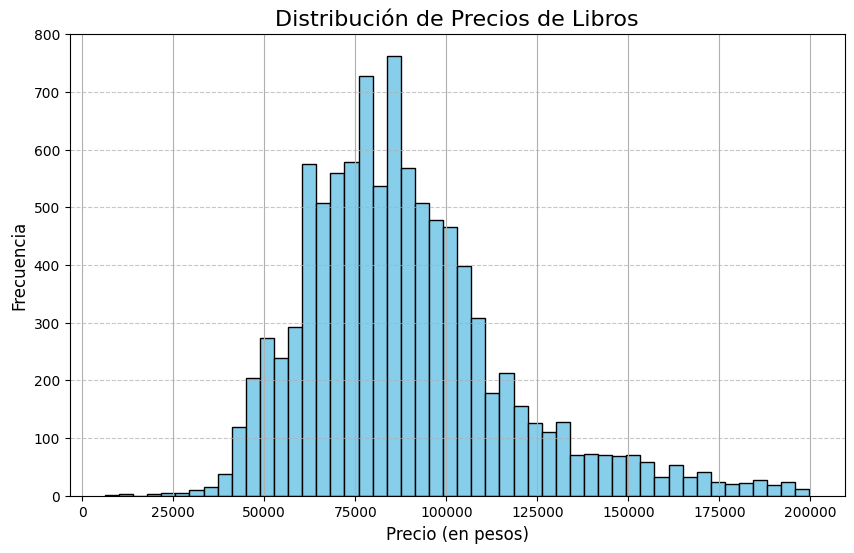

In [21]:
# Filtros para eliminar outliers
filtered_df = df[df['precio'] < 200000]

# Gráfico del histograma
plt.figure(figsize=(10, 6))
filtered_df['precio'].hist(bins=50, color='skyblue', edgecolor='black')
plt.title('Distribución de Precios de Libros', fontsize=16)
plt.xlabel('Precio (en pesos)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


La distribución de los precios de los libros es asimétrica positiva, lo que indica que la mayoría de los precios están concentrados en valores bajos o medios, mientras que hay algunos precios más altos que son menos frecuentes. Los precios más comunes se encuentran en el rango de 50,000 a 100,000 pesos, lo que sugiere que este es el rango típico o estándar para los libros en este conjunto de datos.

En los extremos de la distribución, los precios más bajos, entre 0 y 50,000 pesos, son poco frecuentes. Por otro lado, los precios más altos, que llegan hasta los 200,000 pesos, también son poco comunes, lo que refleja la existencia de libros más costosos en menor cantidad.

El rango de los precios es bastante amplio, desde menos de 50,000 hasta más de 150,000 pesos, lo que denota una diversidad en los costos, probablemente asociada a factores como diferencias en ediciones, editoriales o formatos. Además, la moda, o el precio más repetido, parece situarse cerca de los 75,000 pesos, dado que este es el rango con mayor frecuencia en la distribución.


In [40]:
import json

# Primero, asegúrate de que la columna 'precio' esté limpia y numérica, tal como mencionaste:
df['precio'] = df['precio'].astype(str)  # Asegurarse de que todo es string
df['precio'] = df['precio'].str.replace(r'[^\d]', '', regex=True)  # Remover caracteres no numéricos
df['precio'] = df['precio'].astype(int)  # Convertir a entero

# Crear la columna 'numero_libro_mas_vendido' como categórica, como pediste:
df['numero_libro_mas_vendido'] = range(1, len(df) + 1)  # Asegúrate de numerar los libros en orden
df['numero_libro_mas_vendido'] = df['numero_libro_mas_vendido'].astype('category')

# Obtener solo los primeros 5 libros más vendidos
top_5_libros = df.head(5)

# Ahora vamos a crear el JSON con la información que necesitas de los primeros 5 libros
# Seleccionamos las columnas relevantes
data_json_top_5_libros = top_5_libros[['titulo', 'autor', 'editorial', 'editorial', 'precio', 'estrellas', 'cantidad_calificaciones']].to_dict(orient='records')

# Guardar el JSON en un archivo
with open('top_5_libros_data.json', 'w', encoding='utf-8') as f:
    json.dump(data_json_top_5_libros, f, ensure_ascii=False, indent=4)

# Opcional: Imprimir para verificar
print(json.dumps(data_json_top_5_libros, ensure_ascii=False, indent=4))


[
    {
        "titulo": "1984",
        "autor": "George Orwell",
        "editorial": "Blanco & Negro",
        "precio": 39760,
        "estrellas": 5.0,
        "cantidad_calificaciones": "23"
    },
    {
        "titulo": "Ensayo sobre la ceguera",
        "autor": "José Saramago",
        "editorial": "Debolsillo",
        "precio": 32830,
        "estrellas": 5.0,
        "cantidad_calificaciones": "77"
    },
    {
        "titulo": "Kafka en la Orilla",
        "autor": "Haruki Murakami",
        "editorial": "Tusquets",
        "precio": 45000,
        "estrellas": 5.0,
        "cantidad_calificaciones": "68"
    },
    {
        "titulo": "Cartas del Diablo a Su Sobrino",
        "autor": "C. S. Lewis",
        "editorial": "HarperOne",
        "precio": 55396,
        "estrellas": 5.0,
        "cantidad_calificaciones": "13"
    },
    {
        "titulo": "Un Mundo Feliz",
        "autor": "Aldous Huxley",
        "editorial": "Skala",
        "precio": 13125,
        "es

C:\Users\1531n\AppData\Local\Temp\ipykernel_21276\450699424.py:17: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  data_json_top_5_libros = top_5_libros[['titulo', 'autor', 'editorial', 'editorial', 'precio', 'estrellas', 'cantidad_calificaciones']].to_dict(orient='records')


In [41]:
# Obtener las editoriales más populares (con más libros)
editoriales_destacadas = df['editorial'].value_counts().head(5).reset_index()
editoriales_destacadas.columns = ['Editorial', 'Cantidad_de_Libros']

# Obtener los autores más populares (si tienes una columna 'autor' en tu DataFrame)
autores_populares = df['autor'].value_counts().head(5).reset_index()
autores_populares.columns = ['autor', 'Cantidad_de_Libros']


In [43]:
import json

# Convertir a diccionario
editoriales_json = editoriales_destacadas.to_dict(orient='records')
generos_json = autores_populares.to_dict(orient='records')

# Crear el JSON final con todo
final_json = {
    "top_5_libros": data_json_top_5_libros,
    "editoriales_destacadas": editoriales_json,
    "autores_populares": generos_json
}

# Guardar el JSON en un archivo
with open('libros_analisis.json', 'w', encoding='utf-8') as f:
    json.dump(final_json, f, ensure_ascii=False, indent=4)

# Imprimir el JSON generado (opcional)
print(json.dumps(final_json, ensure_ascii=False, indent=4))


{
    "top_5_libros": [
        {
            "titulo": "1984",
            "autor": "George Orwell",
            "editorial": "Blanco & Negro",
            "precio": 39760,
            "estrellas": 5.0,
            "cantidad_calificaciones": "23"
        },
        {
            "titulo": "Ensayo sobre la ceguera",
            "autor": "José Saramago",
            "editorial": "Debolsillo",
            "precio": 32830,
            "estrellas": 5.0,
            "cantidad_calificaciones": "77"
        },
        {
            "titulo": "Kafka en la Orilla",
            "autor": "Haruki Murakami",
            "editorial": "Tusquets",
            "precio": 45000,
            "estrellas": 5.0,
            "cantidad_calificaciones": "68"
        },
        {
            "titulo": "Cartas del Diablo a Su Sobrino",
            "autor": "C. S. Lewis",
            "editorial": "HarperOne",
            "precio": 55396,
            "estrellas": 5.0,
            "cantidad_calificaciones": "13"
   